# 使用CNN 做分类
---
在这个notebook中，我们要对一个CNN进行定义**并训练**，使其学会对 [Fashion-MNIST 数据库](https://github.com/zalandoresearch/fashion-mnist)的图像进行分类。

我们会提供两种解决方案，向你展示不同的网络结构和训练策略会如何影响CNN的性能和准确性。第二种解决方案，我们选择了一个具有两个卷积层**和**附加的全连接层与dropout层的CNN，避免过度拟合数据和动量梯度下降，最终避免达到局部最小值。训练使用的批次大小和epoch数与第一个解决方案中的相同，这样便于你看到网络结构和损失超参数会如何影响模型的准确性！

同样，这也只是众多可能的解决方案之一。

### 加载 [数据](http://pytorch.org/docs/stable/torchvision/datasets.html) 

在这个单元格中，我们要加载FashionMNIST类中的**训练与测试**数据集。

In [1]:
# our basic libraries
import torch
import torchvision

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors for input into a CNN

## Define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

# choose the training and test datasets
train_data = FashionMNIST(root='./data', train=True,
                                   download=True, transform=data_transform)

test_data = FashionMNIST(root='./data', train=False,
                                  download=True, transform=data_transform)


# Print out some stats about the training and test data
print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

Train data, number of images:  60000
Test data, number of images:  10000


In [2]:
# prepare data loaders, set the batch_size
## TODO: you can try changing the batch_size to be larger or smaller
## when you get to training your network, see how batch_size affects the loss
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### 将一些训练数据可视化

该单元格会遍历该训练数据集，并使用`dataiter.next()`加载一个随机批次的图像/标签数据。然后，它会在`2 x batch_size/2`网格中将这批图像和标签可视化。

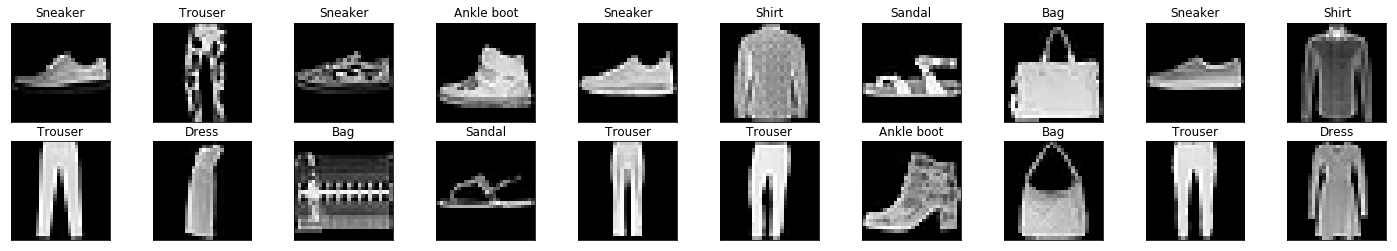

In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])



### 定义网络架构

 [这里](http://pytorch.org/docs/stable/nn.html)记录了构成任何一种神经网络所需的各个层。对于卷积神经网络，我们将使用下列几个简单的层：
* 卷积层
* 最大池化层
* 全连接层（线性层）

此外，我们还建议你考虑添加 [dropout 层](https://pytorch.org/docs/stable/nn.html#dropout)，避免过度拟合此数据。

---

要在PyTorch中定义一个神经网络，你可以选择在函数 `__init__`中定义一个模型的各个层，并定义一个网络的前馈行为，该网络会在函数`forward`中使用这些初始化的层，而该函数会接收输入图像张量`x`。此Net类的结构如下所示，并由你来填写。

注意：在训练期间，PyTorch将能够通过跟踪该网络的前馈行为并使用autograd来计算该网络中权重的更新来执行反向传播。

#### 在` __init__`中定义各层
提醒一下，卷积层/池化层在`__init__`中可以像这样来定义：

In [ ]:
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      

#### 引用`forward`中的层
然后在这样的`forward`函数中引用，其中conv1层在应用最大池化层之前应用了一个ReLu激活函数：

In [ ]:
x = self.pool(F.relu(self.conv1(x)))

在这里，你必须要做的是，要把所有具有可训练权重的层放置在`__init__`函数中，例如卷积层，并在`forward`函数中引用它们。所有始终以相同方式运行的层或函数，例如预定义的激活函数，都可能出现在`__init__`或`forward`函数中。实际上，你之后会经常看到在`__init__`中定义的卷积层/池化层和在`forward`中定义的激活层。

#### 卷积层
你已经定义了第一个卷积层。这个卷积层在用3x3滤镜对图像进行卷积处理之后，会输入1通道的（灰度）图像并输出10个特征图。

#### 扁平化

回想一下，要从卷积层/池化层的输出移动到线性层（即全连接层），必须先将提取的特征扁平化为矢量。如果你使用过深度学习库Keras，可能已经对`Flatten()`有所了解。此外，在PyTorch中，你可以使用`x = x.view(x.size(0), -1)`，将输入 `x`扁平化。

### TODO: 定义其余的层

下面，你可以选择在此网络中定义其他的层，具体取决于你。在这里，我们有一些建议，但你可以根据需要自行更改架构和参数。

建议与提示：
* 至少使用两个卷积层
* 输出必须是一个包含10个输出的线性层（对于10类服装的例子来说）
* 使用一个dropout层，避免过度拟合

### 关于输出大小的说明

对于任何一个卷积层，输出的特征映射图将具有指定的深度（卷积层中10个filter的深度为10），并且可以将所生成的特征映射图（宽度/高度）的尺寸计算为： _输入图像_的宽度/高度W，减去filter大小F，除以步幅S，它们的总和再加上 1。方程是这样的：`output_dim = (W-F)/S + 1`，这里，假设填充大小为0。你可以 [在这里](http://cs231n.github.io/convolutional-networks/#conv)找到这个公式的推导过程。

对于大小为2且步幅为2的池化层，输出维度将减少2倍。阅读下面代码中的注释，查看每个层的输出大小。

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        ## output size = (W-F)/S +1 = (28-3)/1 +1 = 26
        # the output Tensor for one image, will have the dimensions: (10, 26, 26)
        # after one pool layer, this becomes (10, 13, 13)
        self.conv1 = nn.Conv2d(1, 10, 3)
        
        # maxpool layer
        # pool with kernel_size=2, stride=2
        self.pool = nn.MaxPool2d(2, 2)
        
        # second conv layer: 10 inputs, 20 outputs, 3x3 conv
        ## output size = (W-F)/S +1 = (13-3)/1 +1 = 11
        # the output tensor will have dimensions: (20, 11, 11)
        # after another pool layer this becomes (20, 5, 5); 5.5 is rounded down
        self.conv2 = nn.Conv2d(10, 20, 3)
        
        # 20 outputs * the 5*5 filtered/pooled map size
        self.fc1 = nn.Linear(20*5*5, 50)
        
        # dropout with p=0.4
        self.fc1_drop = nn.Dropout(p=0.4)
        
        # finally, create 10 output channels (for the 10 classes)
        self.fc2 = nn.Linear(50, 10)

    # define the feedforward behavior
    def forward(self, x):
        # two conv/relu + pool layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # prep for linear layer
        # this line of code is the equivalent of Flatten in Keras
        x = x.view(x.size(0), -1)
        
        # two linear layers with dropout in between
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        
        # final output
        return x

# instantiate and print your Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.4)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


### 定义损失函数和优化程序

请通过阅读这份在线文档，了解有关 [损失函数](http://pytorch.org/docs/master/nn.html#loss-functions) 和 [优化程序](http://pytorch.org/docs/master/optim.html)的更多信息。

请注意，对于像这样的分类问题，通常要使用交叉熵损失，可以在以下代码中这样定义：`criterion = nn.CrossEntropyLoss()`。PyTorch还包括一些标准的随机优化程序，如随机梯度下降和Adam。我们建议你尝试不同的优化程序，看一看你的模型在训练时对这些不同的优化程序有怎样不同的反应

In [5]:
import torch.optim as optim

## TODO: specify loss function
# using cross entropy whcih combines softmax and NLL loss
criterion = nn.CrossEntropyLoss()

## TODO: specify optimizer 
# stochastic gradient descent with a small learning rate AND some momentum
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 关于准确度的说明

在训练**之前和之后**，要查看该网络的准确度。通过查看准确度，你可以真正看到该神经网络已经学到了什么技能。在下一个单元格中，让我们来看看未经训练的网络的准确度是多少。我们预计它大约为10％，这与我们猜测的所有10个类的准确度相同。

In [6]:
# Calculate accuracy before training
correct = 0
total = 0

# Iterate through test dataset
for images, labels in test_loader:

    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = net(images)

    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()

# calculate the accuracy
# to convert `correct` from a Tensor into a scalar, use .item()
accuracy = 100.0 * correct.item() / total

# print it out!
print('Accuracy before training: ', accuracy)

Accuracy before training:  11.39


### 训练网络

下面，我们已经定义了一个`train`函数，它需要输入多个epoch才能进行训练。
* 其中，epoch数是指神经网络在训练数据集中循环的次数。
* 在epoch循环中，我们会分批遍历训练数据集，每1000批记录一次损失。

以下是此训练函数在训练数据集上迭代时需要执行的步骤：

1. 为正向传递准备零点的梯度
2. 通过网络传递输入（正向传递）
3. 计算损失（预测类与正确标签的距离）
4. 将梯度传播回网络参数（反向传递）
5. 更新权重（参数更新）
6. 输出计算出的损失

In [7]:
def train(n_epochs):
    
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = net(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time


In [8]:
# define the number of epochs to train for
n_epochs = 30 # start small to see if your model works, initially

# call train
training_loss = train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 1.8219456094503403
Epoch: 1, Batch: 2000, Avg. Loss: 1.0009773395061492
Epoch: 1, Batch: 3000, Avg. Loss: 0.8763045960664749
Epoch: 2, Batch: 1000, Avg. Loss: 0.796147280484438
Epoch: 2, Batch: 2000, Avg. Loss: 0.7657720815837383
Epoch: 2, Batch: 3000, Avg. Loss: 0.718777887865901
Epoch: 3, Batch: 1000, Avg. Loss: 0.6800369414836168
Epoch: 3, Batch: 2000, Avg. Loss: 0.6711972561776638
Epoch: 3, Batch: 3000, Avg. Loss: 0.635623934417963
Epoch: 4, Batch: 1000, Avg. Loss: 0.6283947920799255
Epoch: 4, Batch: 2000, Avg. Loss: 0.6125837519019842
Epoch: 4, Batch: 3000, Avg. Loss: 0.6026162989586592
Epoch: 5, Batch: 1000, Avg. Loss: 0.5893838496506214
Epoch: 5, Batch: 2000, Avg. Loss: 0.5897821213230491
Epoch: 5, Batch: 3000, Avg. Loss: 0.5553460112288594
Epoch: 6, Batch: 1000, Avg. Loss: 0.5584453550130128
Epoch: 6, Batch: 2000, Avg. Loss: 0.5491297915056348
Epoch: 6, Batch: 3000, Avg. Loss: 0.5475381933003663
Epoch: 7, Batch: 1000, Avg. Loss: 0.5289496246054

## 将损失可视化

要想知道随着时间的推移，你的神经网络在训练时学会了多少，一个很好的指标是查看这期间损失的多少。在这个例子中，我们输出并记录了每1000个批次和每个epoch的平均损失。让我们将其可视化，看一看损失随着时间的推移有所减少，或者没有减少。

在这个示例中，你会看到，最开始很快就会出现大量的损失，但是随着时间的推移，损失会逐渐在一些小的线性数量上有所减少。

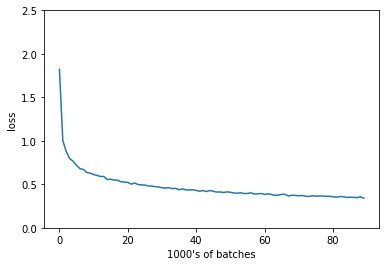

In [9]:
# visualize the loss as the network trained
plt.plot(training_loss)
plt.xlabel('1000\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 2.5) # consistent scale
plt.show()



### 对已训练的网络进行测试

只要你对模型的损失减少感到满意，就可以进行最后一步了，那就是测试！

现在，你必须要使用之前从未见过的数据集测试这个已训练的模型，从而查看它是否能够很好地概括并准确地对这个新数据集进行分类。对于包含许多预处理训练图像的FashionMNIST，一个好的模型在该测试数据集上的**准确度应该达到85％以上**。如果未达到此值，请尝试使用更多epoch进行训练，调整超参数，或添加/减少CNN中的层。

In [10]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.320683

Test Accuracy of T-shirt/top: 81% (818/1000)
Test Accuracy of Trouser: 97% (971/1000)
Test Accuracy of Pullover: 82% (820/1000)
Test Accuracy of Dress: 90% (904/1000)
Test Accuracy of  Coat: 79% (798/1000)
Test Accuracy of Sandal: 97% (975/1000)
Test Accuracy of Shirt: 67% (677/1000)
Test Accuracy of Sneaker: 95% (952/1000)
Test Accuracy of   Bag: 97% (972/1000)
Test Accuracy of Ankle boot: 95% (951/1000)

Test Accuracy (Overall): 88% (8838/10000)


### 将样本测试结果可视化

格式：预测的类（真实的类）

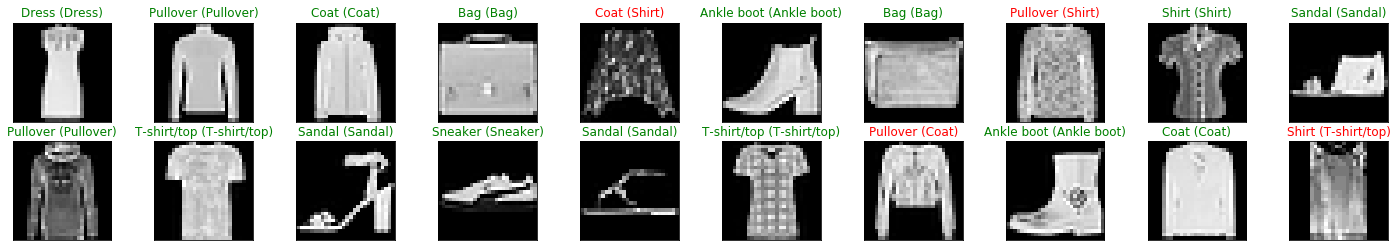

In [11]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))



### 问题：你的模型存在哪些缺点？在未来的迭代中，你会如何改进它们？

**答案**: 由于T恤、衬衫和外套的整体外型非常相似，我的模型很难把它们区分开来。事实上，测试中，类的准确度最低的是：`Test Accuracy of Shirt`，这个模型对这类衣服的准确度只有大约60％左右。

我认为，通过对这些类进行一些数据扩充，或者添加另一个卷积层来提取更高级别的特征，就可以提高准确度。

In [12]:
# Saving the model
model_dir = 'saved_models/'
model_name = 'fashion_net_ex.pt'

# after training, save your model parameters in the dir 'saved_models'
# when you're ready, un-comment the line below
torch.save(net.state_dict(), model_dir+model_name)